# Model reduction and foliation in a nonlinear oscillator chain 

We now analyze the dynamics of a chain of oscillators, which has been treated in the SSMLearn package Cenedese et al. 2022. 

Denoting the positions of the oscillators as $q_{i}$ for $i=1,...,5,$ we assume that the springs and dampers are linear, except for the first oscillator. The non-dimensionalized equations of motion can be written as 

$$
\mathbf{M\ddot{\mathbf{q}}}+\mathbf{C}\dot{\mathbf{q}}+\mathbf{K}\mathbf{q}+\mathbf{f}(\mathbf{q},\dot{\mathbf{q}})=\mathbf{0},
$$
where $\mathbf{M}=\mathbf{I}$; the springs have the same linear stiffness $k=1$ which is encoded in $\mathbf{K}$ via nearest-neighbor coupling. 
The damping is assumed to be proportional, i.e., we specifically set 
$$
\mathbf{C}=0.002\mathbf{M}+0.005\mathbf{K}.
$$
    

The trajectories have been generated by ```SSMLearn``` and are available at https://github.com/haller-group/SSMLearn

In [1]:
%load_ext autoreload
%autoreload 2
%aimport datadrivenlinearization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


In [3]:
ydat = loadmat('data/osc_chain_4d.mat')['yData']

Here we fit a full linearization to trajectories after a convergence to a 4D SSM has taken place. 

For the 4D SSM, we assume a linear parametrization. Following https://github.com/haller-group/SSMLearn, the tangent space is approximated via DMD

In [4]:
XX = np.concatenate([y[1] for y in ydat],axis = 1)

In [5]:
list_of = [y[1].T for y in ydat]

In [6]:
import pydmd

In [7]:
model = pydmd.DMD(svd_rank=4)

In [8]:
model.fit(list_of[0].T)

In [9]:
%matplotlib inline

In [10]:
mm1 = model.modes[:,0]
mm2 = model.modes[:,2]


In [11]:
projector = np.vstack([mm1.real,mm1.imag, mm2.real, mm2.imag])

In [12]:
reduced_coordinates = projector@ydat[0][1]

The first 3 coordinates of the reduced phase can be visualized as

In [13]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})

Text(0.5, 0, '$\\varphi_3$')

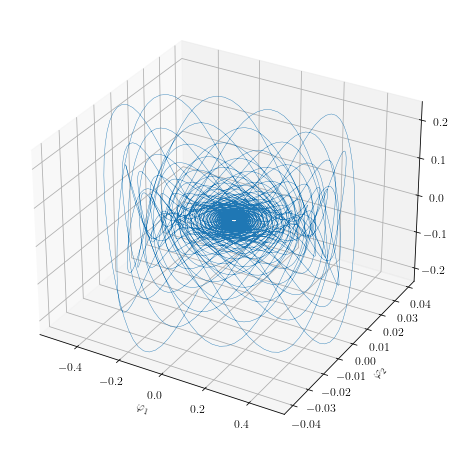

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(reduced_coordinates[0,:], reduced_coordinates[1,:], reduced_coordinates[2,:], linewidth =0.4)
ax.set_xlabel('$\\varphi_1$')
ax.set_ylabel('$\\varphi_2$')
ax.set_zlabel('$\\varphi_3$')

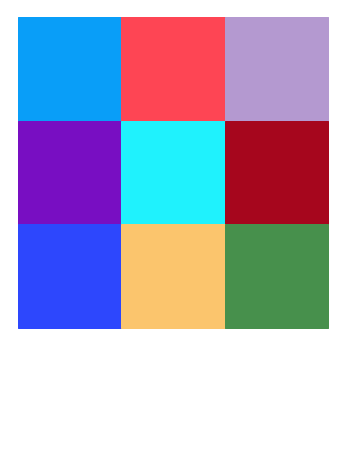

In [307]:
import distinctipy 
colors2 = distinctipy.get_colors(9, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
distinctipy.color_swatch(colors2)

In [212]:
reduced_coords = [projector @ y[1] for y in ydat]
del reduced_coords[4]

In [213]:
reduced_coord_test = [projector @ ydat[-1][1]]

In [214]:
del reduced_coords[-1]

In [215]:
init_matrix = model.atilde

In [216]:
reduced_coords = [r[:,::10] for r in reduced_coords]

In [217]:
reduced_coord_test = [r[:,::10] for r in reduced_coord_test]

In [218]:
teval = ydat[0][0][0,:]

## Fitting the DDL model

In [23]:
%%time
degree = 3
dimension = 4
d = datadrivenlinearization.DataDrivenLinearization(dimension, degree = degree, approximate = False)
d.fit_lsq_inv(reduced_coords, alpha = 0, initial_matrix=init_matrix, initial_transformation='zero',  method = 'trf')


Initial cost:  52.80100323937051
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.538e-04  1.182e-04 ...  1.698e-08  2.471e-08]
           x: [ 8.108e-01  7.290e+00 ...  2.083e-01  3.880e+00]
        cost: 0.0010826899395125593
         jac: [[ 1.282e-01 -3.598e-02 ...  0.000e+00  0.000e+00]
               [-1.677e-01 -3.799e-02 ...  0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ...  4.547e-13 -1.172e-13]
               [ 0.000e+00  0.000e+00 ...  0.000e+00 -7.032e-13]]
        grad: [ 9.240e-10 -8.387e-12 ...  2.898e-12 -3.198e-12]
  optimality: 3.4358632874584294e-09
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 20
        njev: 20
Final cost:  0.002165379879025118
CPU times: user 40 s, sys: 1.49 s, total: 41.5 s
Wall time: 41.5 s


0.002165379879025118

In [24]:
v, w = np.linalg.eig(d.linear_model)

dt = (teval[1] - teval[0])*10
Diag_cont_init = np.diag(np.log(v)/dt)

Cont_non_diag = np.real(w@Diag_cont_init@np.linalg.inv(w))


In [25]:
pred = d.predict(reduced_coords[0][:,0], reduced_coords[0].shape[1]-1)

In [26]:
predicted_ddl = np.array(pred)


In [27]:
def simulate_unforced(t, x):
    xx = x.reshape(-1,1)
    return Cont_non_diag @ x

In [278]:
tmax = teval[-1]

In [279]:
transformed = d.transform(reduced_coord_test[0])

In [280]:
from scipy.integrate import solve_ivp

In [281]:
pred = solve_ivp(simulate_unforced, [0, tmax], transformed[0,:], t_eval = figure_['teval'],  method = 'DOP853')
untrf_pred = d.inverse_transform(pred.y)
#tocompare = d.transform(reduced_coords[0]).T

In [282]:
colors3 = distinctipy.get_colors(15, n_attempts = 7000, rng = 1, colorblind_type='Deuteranomaly')
#distinctipy.color_swatch(colors3)

## Computing the SSM

The eigenspaces are not necessarily normal, therefore we compute the SSM of the linearized system as the slow subspace spanned by the slow eigenvectors.

In [234]:
%matplotlib widget

In [33]:
fraction1 = np.linspace(-0.5, 0.5, 30)
fraction2 = np.linspace(-0.5, 0.5, 30)

F1, F2 = np.meshgrid(fraction1, fraction2)

In [34]:
coords = np.vstack((F1.ravel(),F2.ravel()))

In [35]:
linear_ssmplane_coords = coords[0,:].reshape((900,1))*w[:,0].real + coords[1,:].reshape((900,1))*w[:,0].imag

In [36]:
nonlinear_ssm = [d.inverse_transform(s.reshape(-1,1)) for s in linear_ssmplane_coords]

In [37]:
nonlinear_ssm = np.squeeze(np.array(nonlinear_ssm))

In [38]:
import matplotlib.tri as mtri
tri = mtri.Triangulation(F1.ravel(), F2.ravel())

In [39]:
leading_eigval = np.log(v[0])/dt

In [40]:
reduced_mtx = np.array([[leading_eigval.real,leading_eigval.imag],
                        [-leading_eigval.imag,leading_eigval.real]])

In [41]:
diagonalizing_transform = np.vstack((w[:,0].real, w[:,0].imag, w[:,2].real,w[:,2].imag)).T

In [42]:
Diagonalized = np.linalg.inv(diagonalizing_transform)@Cont_non_diag@diagonalizing_transform


In [43]:
Diagonalized_reduced = Diagonalized[:2,:2]

In [44]:
def reduced_model(t,x):
    return Diagonalized_reduced@x

In [155]:
def predict_on_2DSSM(x, teval):
    x_linearized = np.squeeze(d.transform(x.reshape(-1,1)))
    x_linearized_projected = (np.linalg.inv(diagonalizing_transform)@x_linearized)[:2]
    sol = solve_ivp(reduced_model, [teval[0], teval[-1]], x_linearized_projected, t_eval = teval)
    sol_lift = diagonalizing_transform@(np.concatenate((sol.y,sol.y*0))) 
    
    return d.inverse_transform(sol_lift)
    

In [156]:
ssm_2d_prediction = predict_on_2DSSM(reduced_coord_test[0][:,0], teval[::10])

Text(0, 0.5, 'Reduced coordinate')

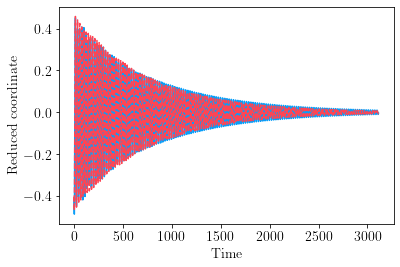

In [157]:
plt.figure()
plt.plot(teval[::10], reduced_coord_test[0][0,:], '-', c=colors2[0])
plt.plot(teval[::10], ssm_2d_prediction[0,:], '--', c=colors2[1])
plt.xlabel('Time')
plt.ylabel('Reduced coordinate')


In the linear phase space, the leaves of the foliation are 

$$
(\gamma_{1,0},\gamma_{2,0}, x, y) 
$$

for a fixed $(\gamma_{1,0},\gamma_{2,0})$

To simplify the visualization, let's fix $\gamma_{2,0}=0$

In [158]:
fraction1_leaves = np.linspace(-1, 1, 30)
fraction2_leaves = np.linspace(-1,1, 30)

F1_l, F2_l = np.meshgrid(fraction1_leaves, fraction2_leaves)
coords_leaves = np.vstack((F1_l.ravel(),F2_l.ravel()))

In [159]:
fraction1 = np.linspace(-0.5, 0.5, 1000)

leaves_linear = [ np.vstack((coords_leaves[0,:]*0 + x0, coords_leaves[0,:]*0,coords_leaves)) for x0 in fraction1]

In [160]:
leaves_linear_transformed = [diagonalizing_transform@x for x in leaves_linear]

In [161]:
leaves_nonlinear = [d.inverse_transform(x) for  x in leaves_linear_transformed]

In [162]:
reduced_coords = [projector @ y[1] for y in ydat]

In [163]:
reduced_coords_linear = [d.transform(p).T for p in reduced_coords]

In [164]:
x_linearized_projected = [(np.linalg.inv(diagonalizing_transform)@r)[:2] for r in reduced_coords_linear]
x_linearized_untransformed = [diagonalizing_transform@(np.concatenate((r,r*0))) for r in x_linearized_projected ]

In [165]:
x_linearized_untransformed = np.squeeze(d.transform(ssm_2d_prediction)).T

In [166]:
linear_data = {}
linear_data['leaves_linear'] = leaves_linear_transformed
linear_data['linear_ssm'] = linear_ssmplane_coords
linear_data['linear_trajectory'] = reduced_coords_linear
linear_data['linear_projected'] = x_linearized_untransformed
nonlinear_data = {}
nonlinear_data['leaves_nonlinear'] = leaves_nonlinear
nonlinear_data['nonlinear_ssm'] = nonlinear_ssm
nonlinear_data['nonlinear_trajectory'] = reduced_coords
nonlinear_data['nonlinear_projected'] = ssm_2d_prediction


Text(0.5, 0, '$\\gamma_3$')

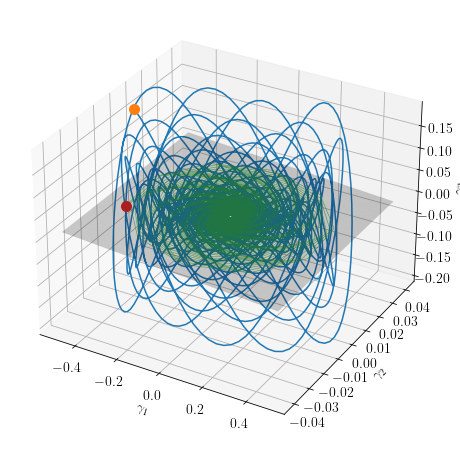

In [167]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_trisurf(linear_ssmplane_coords[:,0],linear_ssmplane_coords[:,1],linear_ssmplane_coords[:,2], triangles=tri.triangles, color='black', alpha = 0.2)

init = 30
ax.plot(reduced_coords_linear[0][0,init:], reduced_coords_linear[0][1,init:],reduced_coords_linear[0][2,init:])
ax.plot(reduced_coords_linear[0][0,init], reduced_coords_linear[0][1,init],reduced_coords_linear[0][2,init], 'o', markersize = 10)
ax.plot(x_linearized_untransformed[0,init:], x_linearized_untransformed[1,init:],x_linearized_untransformed[2,init:], '-', linewidth = 0.6, alpha = 0.7)
ax.plot(x_linearized_untransformed[0,init], x_linearized_untransformed[1,init],x_linearized_untransformed[2,init], 'o', markersize = 10)

ax.set_xlabel('$\\gamma_1$')
ax.set_ylabel('$\\gamma_2$')
ax.set_zlabel('$\\gamma_3$')


Text(0.5, 0, '$\\varphi_3$')

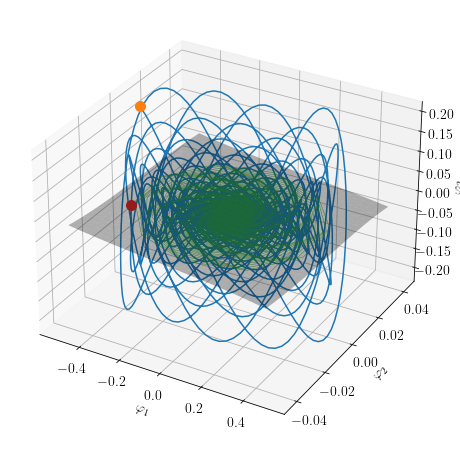

In [168]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_trisurf(nonlinear_ssm[:,0],nonlinear_ssm[:,1],nonlinear_ssm[:,2], triangles=tri.triangles, color='black', alpha = 0.3)

init = 30
ax.plot(reduced_coords[0][0,init:], reduced_coords[0][1,init:],reduced_coords[0][2,init:])
ax.plot(reduced_coords[0][0,init], reduced_coords[0][1,init],reduced_coords[0][2,init], 'o', markersize = 10)
ax.plot(ssm_2d_prediction[0,init:], ssm_2d_prediction[1,init:],ssm_2d_prediction[2,init:], '-', linewidth = 0.6, alpha = 0.7)
ax.plot(ssm_2d_prediction[0,init], ssm_2d_prediction[1,init],ssm_2d_prediction[2,init], 'o', markersize = 10)
ax.set_xlabel('$\\varphi_1$')
ax.set_ylabel('$\\varphi_2$')
ax.set_zlabel('$\\varphi_3$')


## Reduced-order model based on DMD and EDMD


In [285]:
figure_ = {}
figure_['reduced_coords'] = reduced_coords
figure_['reduced_coords_test'] = reduced_coord_test

figure_['ddl_on_2d_ssm'] = ssm_2d_prediction
figure_['ddl_on_4d_ssm'] = untrf_pred
figure_['teval'] = teval[::10]

In [286]:
deg = 4
dmd = datadrivenlinearization.DMD(reduced_coords)
edmd = datadrivenlinearization.EDMD(reduced_coords, degree = deg)

In [287]:
model = pydmd.DMD(svd_rank = 4)

In [288]:
model.fit(reduced_coords[0])

In [289]:
from sklearn.preprocessing import PolynomialFeatures

In [290]:

nonlin_features = PolynomialFeatures(degree = 4, 
                                     include_bias = False).fit_transform(reduced_coord_test[0].T)


In [291]:
def iterate(x0, A, n):
    iterates = [x0]
    for i in range(n):
        iterates.append(A@iterates[-1])
    return iterates

In [292]:
dmd_pred_4d = np.array(iterate(reduced_coord_test[0][:,0],
                            dmd.coef_, 
                            figure_['teval'].shape[0] -1))

edmd_pred_4d = np.array(iterate(nonlin_features[0,:],
                            edmd.coef_, 
                            figure_['teval'].shape[0] -1))



In [293]:
figure_['dmd_4d'] = dmd_pred_4d.T
figure_['edmd_4d'] = edmd_pred_4d.T

In [294]:
deg = 3
dmd = datadrivenlinearization.DMD([r[:2, :] for r in reduced_coords])
edmd = datadrivenlinearization.EDMD([r[:2, :] for r in reduced_coords], degree = deg)

In [295]:
teval.shape

(14001,)

In [296]:
nonlin_features = PolynomialFeatures(degree = 3,
                                     include_bias = False).fit_transform(reduced_coord_test[0][:2, :].T)


In [297]:
dmd_pred_2d = np.array(iterate(reduced_coord_test[0][:2,0],
                            dmd.coef_, 
                            figure_['teval'].shape[0] -1))

edmd_pred_2d = np.array(iterate(nonlin_features[0,:],
                            edmd.coef_, 
                            figure_['teval'].shape[0] -1))



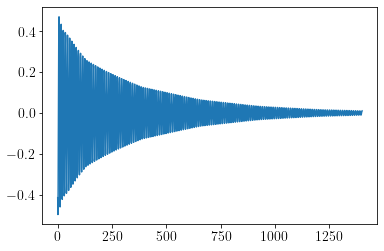

In [298]:
plt.plot(edmd_pred_2d[:,0])

In [299]:
figure_['dmd_2d'] = dmd_pred_2d.T
figure_['edmd_2d'] = edmd_pred_2d.T

In [300]:
reduced_coords[0].shape

(4, 1401)

## Create the comparison figure

In [327]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14,"font.family": "serif",})

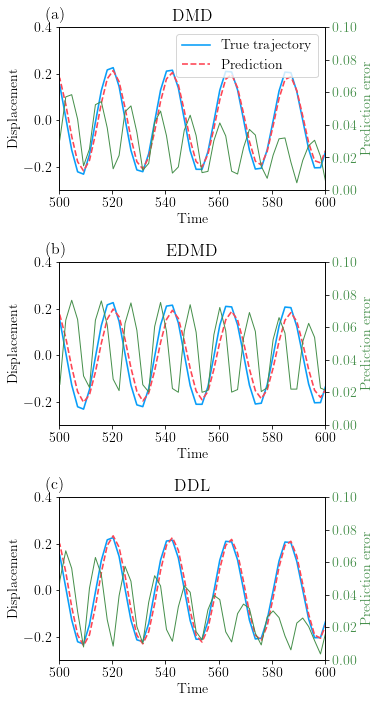

In [328]:
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (5.5,10))

axes[0].plot(figure_['teval'], figure_['reduced_coords_test'][0][0,:],  '-',
               linewidth = 1.6,  c=colors2[0], label = 'True trajectory')

axes[0].plot(figure_['teval'], figure_['dmd_2d'][0,:], '--', 
               linewidth = 1.6, alpha = 1, c=colors2[1], label = 'Prediction')
ax1 = axes[0].twinx()  # instantiate a second Axes that shares the same x-axis
ax1.plot(figure_['teval'], np.linalg.norm(figure_['dmd_2d'] - figure_['reduced_coords_test'][0][:2,:], axis = 0 ), '-', 
               linewidth = 1, alpha = 1, c=colors2[8])
ax1.tick_params(axis='y', labelcolor=colors2[8])
ax1.set_ylim(0, 0.1)
ax1.set_ylabel('Prediction error', color = colors2[8])
axes[0].set_title('DMD')


axes[1].plot(figure_['teval'], figure_['reduced_coords_test'][0][0,:],  '-',
               linewidth = 1.6,  c=colors2[0])

axes[1].plot(figure_['teval'], figure_['edmd_2d'][0,:], '--', 
               linewidth = 1.6, alpha = 1, c=colors2[1])
axes[1].set_title('EDMD')
ax2 = axes[1].twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(figure_['teval'], np.linalg.norm(figure_['edmd_2d'][:2, :] - figure_['reduced_coords_test'][0][:2,:], axis = 0 ), '-', 
               linewidth = 1, alpha = 1, c=colors2[8])
ax2.tick_params(axis='y', labelcolor=colors2[8])
ax2.set_ylim(0, 0.1)
ax2.set_ylabel('Prediction error', color = colors2[8])

axes[2].plot(figure_['teval'], figure_['reduced_coords_test'][0][0,:],  '-',
               linewidth = 1.6,  c=colors2[0])

axes[2].plot(figure_['teval'], figure_['ddl_on_2d_ssm'][0,:], '--', 
               linewidth = 1.6, alpha = 1, c=colors2[1])
axes[2].set_title('DDL')
ax3 = axes[2].twinx()  # instantiate a second Axes that shares the same x-axis
ax3.plot(figure_['teval'], np.linalg.norm(figure_['ddl_on_2d_ssm'][:2, :] - figure_['reduced_coords_test'][0][:2,:], axis = 0 ), '-', 
               linewidth = 1, alpha = 1, c=colors2[8])
ax3.tick_params(axis='y', labelcolor=colors2[8])
ax3.set_ylim(0, 0.1)
ax3.set_ylabel('Prediction error', color = colors2[8])


for a in axes.ravel():
    a.set_xlim(500, 600)
    
    
axes[0].legend(fontsize = 14, loc = 'upper right')
fig.tight_layout()
for a in axes:
    
    a.set_ylabel('Displacement')


for i in range(3):
    axes[i].set_xlabel('Time')
    axes[i].set_ylim(-0.3,0.4)
    
    
    
labels = ['(a)', '(b)', '(c)']
for a,l in zip(axes.ravel(), labels):
    a.text(-0.05, 1.05, l,transform=a.transAxes, fontsize = 16)
fig.tight_layout()
plt.savefig("osc_chain_modified.pdf", bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (14001,) and (1401,)

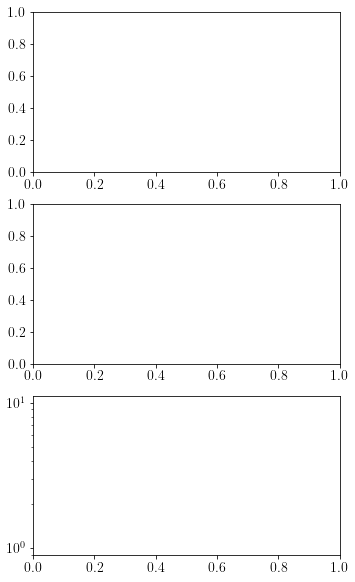

In [324]:
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (5.5,10))

axes[2].semilogy(teval, np.abs(figure_['reduced_coords_test'][0][0,:] - figure_['dmd_2d'][0,:]),  '-',
               linewidth = 1.6,  c=colors2[0], label = 'True trajectory')

# axes[0].plot(teval, figure_['dmd_2d'][0,:], '--', 
#                linewidth = 1.6, alpha = 1, c=colors2[1], label = 'Prediction')
axes[0].set_title('DMD')


# axes[2].semilogy(teval, np.abs(figure_['reduced_coords_test'][0][0,:] - figure_['edmd_2d'][0,:]),  '-',
#                linewidth = 1.6,  c=colors2[0])

# axes[1].plot(teval, figure_['edmd_2d'][0,:], '--', 
#                linewidth = 1.6, alpha = 1, c=colors2[1])
axes[1].set_title('EDMD')


axes[2].semilogy(teval[::10], np.abs(figure_['reduced_coords_test'][0][0,:][::10] - figure_['ddl_on_2d_ssm'][0,:]),  '--',
               linewidth = 1.6,  c='black')

# axes[2].plot(figure_['teval'], figure_['ddl_on_2d_ssm'][0,:], '--', 
#                linewidth = 1.6, alpha = 1, c=colors2[1])
axes[2].set_title('DDL')


for a in axes.ravel():
#    a.set_xlim(700, 800)
    a.set_ylim(1e-4, 1e-1)
    
axes[0].legend(fontsize = 14, loc = 'upper right')
fig.tight_layout()
for a in axes:
    
    a.set_ylabel('Displacement')


for i in range(3):
    axes[i].set_xlabel('Time')
    axes[i].set_ylim(-0.37,0.37)
    
    
    
labels = ['(a)', '(b)', '(c)']
for a,l in zip(axes.ravel(), labels):
    a.text(-0.05, 1.05, l,transform=a.transAxes, fontsize = 16)
fig.tight_layout()
